In [11]:
# Importar datos localmente -> es lento y quizá es mejor importar desde drive
from google.colab import files
uploaded = files.upload()

#from google.colab import drive
#drive.mount('/content/drive')

Saving train_data.csv to train_data (1).csv


In [71]:
!pip install --upgrade tensorflow
!pip install keras-tuner

In [0]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow.keras
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import kerastuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [0]:
timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -30
fill_X = -0.25
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11

#RNN hiperparameter
epochs = 20
batch = 64
val_split = 0.25
test_split = 0.25

In [150]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train_data.csv']))
df

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.013826,0.007173,0.000051,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,7.373471e+05,4.429923e+16,4.057932,266.722309,137.617114,54366.864909,1.781418,46.612573,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.013487,0.009139,0.000060,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,1.141390e+05,4.378610e+16,3.526780,262.191819,56.070117,54082.067268,1.800959,46.595869,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.013357,0.007057,0.000060,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,4.696004e+04,4.369105e+16,3.362037,261.666544,37.497947,54027.391201,1.821940,46.592757,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,

In [151]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

(7311, 17, 124) (7311, 1)


In [152]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric, 
                                                    stratify=y_train_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 799.0, 4112.0, 0.194
VAL   267.0, 1371.0, 0.195
TEST  356.0, 1828.0, 0.195


In [0]:
# Model activation selu
def build_model(hp):

    model = Sequential()

    model.add(Input(batch_shape=(None, timestep, X_train.shape[2])))

    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=4,max_value=128,step=4),
                       stateful=False,
                       dropout=hp.Float(f'lstm_{i}_dp', min_value=0.,max_value=0.4,step=0.1),
                       recurrent_dropout=hp.Float(f'lstm_{i}_rdp',min_value=0.,max_value=0.6,step=0.1),
                       return_sequences=True))

    model.add(LSTM(hp.Int(f'lstm_last_units',min_value=4,max_value=128,step=4),
                   stateful=False,
                   dropout=hp.Float(f'lstm_last_dp',min_value=0.,max_value=0.4,step=0.1),
                   recurrent_dropout=hp.Float(f'lstm_last_rdp',min_value=0.,max_value=0.6,step=0.1),
                   return_sequences=False))

    model.add(Dense(units = 1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(hp.Choice('learning_rate', [2e-3, 1e-3, 5e-4])),
                  metrics=['accuracy'])

    return model

In [154]:
import time

LOG_DIR = f"{int(time.time())}"

tuner = RandomSearch(build_model,
                     objective='val_acc',
                     max_trials=15,  # how many model variations to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR)

tuner.search_space_summary()

In [155]:
tuner.search(x=X_train,
             y=y_train,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=epochs,
             batch_size=batch,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_val, y_val))

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 6s - loss: 0.5196 - acc: 0.7896 - val_loss: 0.4850 - val_acc: 0.8053
Epoch 2/20
4112/4112 - 4s - loss: 0.4790 - acc: 0.8059 - val_loss: 0.4703 - val_acc: 0.8053
Epoch 3/20
4112/4112 - 4s - loss: 0.4590 - acc: 0.8067 - val_loss: 0.4408 - val_acc: 0.8067
Epoch 4/20
4112/4112 - 4s - loss: 0.4455 - acc: 0.8103 - val_loss: 0.4296 - val_acc: 0.8067
Epoch 5/20
4112/4112 - 4s - loss: 0.4323 - acc: 0.8101 - val_loss: 0.4045 - val_acc: 0.8067
Epoch 6/20
4112/4112 - 4s - loss: 0.4213 - acc: 0.8096 - val_loss: 0.4008 - val_acc: 0.8206
Epoch 7/20
4112/4112 - 4s - loss: 0.4129 - acc: 0.8154 - val_loss: 0.3849 - val_acc: 0.8198
Epoch 8/20
4112/4112 - 4s - loss: 0.4042 - acc: 0.8137 - val_loss: 0.3836 - val_acc: 0.8096
Epoch 9/20
4112/4112 - 4s - loss: 0.3971 - acc: 0.8183 - val_loss: 0.3777 - val_acc: 0.8096
Epoch 10/20
4112/4112 - 4s - loss: 0.3869 - acc: 0.8208 - val_loss: 0.3702 - val_acc: 0.8279
Epoch 11/20
4112/4112 - 4s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 10s - loss: 0.4887 - acc: 0.8008 - val_loss: 0.4462 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 8s - loss: 0.4463 - acc: 0.8123 - val_loss: 0.4054 - val_acc: 0.8169
Epoch 3/20
4112/4112 - 7s - loss: 0.4214 - acc: 0.8067 - val_loss: 0.3854 - val_acc: 0.8264
Epoch 4/20
4112/4112 - 8s - loss: 0.4061 - acc: 0.8171 - val_loss: 0.3801 - val_acc: 0.8169
Epoch 5/20
4112/4112 - 8s - loss: 0.3843 - acc: 0.8273 - val_loss: 0.3672 - val_acc: 0.8213
Epoch 6/20
4112/4112 - 8s - loss: 0.3768 - acc: 0.8200 - val_loss: 0.3616 - val_acc: 0.8388
Epoch 7/20
4112/4112 - 8s - loss: 0.3734 - acc: 0.8261 - val_loss: 0.3668 - val_acc: 0.8271
Epoch 8/20
4112/4112 - 8s - loss: 0.3733 - acc: 0.8210 - val_loss: 0.3455 - val_acc: 0.8366
Epoch 9/20
4112/4112 - 8s - loss: 0.3565 - acc: 0.8324 - val_loss: 0.3393 - val_acc: 0.8366
Epoch 10/20
4112/4112 - 8s - loss: 0.3555 - acc: 0.8322 - val_loss: 0.3400 - val_acc: 0.8395
Epoch 11/20
4112/4112 - 8s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 12s - loss: 0.4573 - acc: 0.7979 - val_loss: 0.4242 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 9s - loss: 0.4147 - acc: 0.8137 - val_loss: 0.3916 - val_acc: 0.8082
Epoch 3/20
4112/4112 - 9s - loss: 0.3794 - acc: 0.8220 - val_loss: 0.3511 - val_acc: 0.8344
Epoch 4/20
4112/4112 - 9s - loss: 0.3617 - acc: 0.8266 - val_loss: 0.3438 - val_acc: 0.8344
Epoch 5/20
4112/4112 - 9s - loss: 0.3476 - acc: 0.8320 - val_loss: 0.3337 - val_acc: 0.8373
Epoch 6/20
4112/4112 - 9s - loss: 0.3332 - acc: 0.8344 - val_loss: 0.3284 - val_acc: 0.8308
Epoch 7/20
4112/4112 - 9s - loss: 0.3335 - acc: 0.8412 - val_loss: 0.3260 - val_acc: 0.8432
Epoch 8/20
4112/4112 - 9s - loss: 0.3345 - acc: 0.8410 - val_loss: 0.3114 - val_acc: 0.8432
Epoch 9/20
4112/4112 - 9s - loss: 0.3116 - acc: 0.8468 - val_loss: 0.3106 - val_acc: 0.8439
Epoch 10/20
4112/4112 - 9s - loss: 0.3228 - acc: 0.8446 - val_loss: 0.3076 - val_acc: 0.8410
Epoch 11/20
4112/4112 - 9s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 10s - loss: 0.4868 - acc: 0.7974 - val_loss: 0.4574 - val_acc: 0.8096
Epoch 2/20
4112/4112 - 8s - loss: 0.4315 - acc: 0.8108 - val_loss: 0.4075 - val_acc: 0.8140
Epoch 3/20
4112/4112 - 8s - loss: 0.4039 - acc: 0.8137 - val_loss: 0.3815 - val_acc: 0.8242
Epoch 4/20
4112/4112 - 8s - loss: 0.3836 - acc: 0.8188 - val_loss: 0.3876 - val_acc: 0.8315
Epoch 5/20
4112/4112 - 8s - loss: 0.3773 - acc: 0.8237 - val_loss: 0.3512 - val_acc: 0.8249
Epoch 6/20
4112/4112 - 8s - loss: 0.3601 - acc: 0.8286 - val_loss: 0.3535 - val_acc: 0.8352
Epoch 7/20
4112/4112 - 8s - loss: 0.3489 - acc: 0.8290 - val_loss: 0.3294 - val_acc: 0.8395
Epoch 8/20
4112/4112 - 8s - loss: 0.3438 - acc: 0.8405 - val_loss: 0.3254 - val_acc: 0.8395
Epoch 9/20
4112/4112 - 8s - loss: 0.3315 - acc: 0.8439 - val_loss: 0.3240 - val_acc: 0.8359
Epoch 10/20
4112/4112 - 8s - loss: 0.3289 - acc: 0.8410 - val_loss: 0.3112 - val_acc: 0.8446
Epoch 11/20
4112/4112 - 8s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 6s - loss: 0.5778 - acc: 0.7850 - val_loss: 0.4946 - val_acc: 0.8053
Epoch 2/20
4112/4112 - 3s - loss: 0.4851 - acc: 0.8057 - val_loss: 0.4876 - val_acc: 0.8053
Epoch 3/20
4112/4112 - 3s - loss: 0.4856 - acc: 0.8064 - val_loss: 0.4843 - val_acc: 0.8053
Epoch 4/20
4112/4112 - 3s - loss: 0.4824 - acc: 0.8067 - val_loss: 0.4845 - val_acc: 0.8053
Epoch 5/20
4112/4112 - 3s - loss: 0.4797 - acc: 0.8059 - val_loss: 0.4784 - val_acc: 0.8060
Epoch 6/20
4112/4112 - 3s - loss: 0.4749 - acc: 0.8071 - val_loss: 0.4729 - val_acc: 0.8067
Epoch 7/20
4112/4112 - 3s - loss: 0.4685 - acc: 0.8069 - val_loss: 0.4640 - val_acc: 0.8067
Epoch 8/20
4112/4112 - 3s - loss: 0.4572 - acc: 0.8074 - val_loss: 0.4505 - val_acc: 0.8067
Epoch 9/20
4112/4112 - 3s - loss: 0.4500 - acc: 0.8071 - val_loss: 0.4435 - val_acc: 0.8067
Epoch 10/20
4112/4112 - 3s - loss: 0.4474 - acc: 0.8081 - val_loss: 0.4447 - val_acc: 0.8067
Epoch 11/20
4112/4112 - 3s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 10s - loss: 0.4869 - acc: 0.8018 - val_loss: 0.4594 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 8s - loss: 0.4587 - acc: 0.8081 - val_loss: 0.4430 - val_acc: 0.8074
Epoch 3/20
4112/4112 - 8s - loss: 0.4418 - acc: 0.8069 - val_loss: 0.4263 - val_acc: 0.8082
Epoch 4/20
4112/4112 - 8s - loss: 0.4276 - acc: 0.8098 - val_loss: 0.4052 - val_acc: 0.8074
Epoch 5/20
4112/4112 - 8s - loss: 0.4120 - acc: 0.8137 - val_loss: 0.4217 - val_acc: 0.8140
Epoch 6/20
4112/4112 - 8s - loss: 0.4040 - acc: 0.8157 - val_loss: 0.3759 - val_acc: 0.8249
Epoch 7/20
4112/4112 - 8s - loss: 0.3974 - acc: 0.8188 - val_loss: 0.3658 - val_acc: 0.8344
Epoch 8/20
4112/4112 - 8s - loss: 0.3846 - acc: 0.8200 - val_loss: 0.3594 - val_acc: 0.8271
Epoch 9/20
4112/4112 - 8s - loss: 0.3746 - acc: 0.8351 - val_loss: 0.3426 - val_acc: 0.8337
Epoch 10/20
4112/4112 - 8s - loss: 0.3718 - acc: 0.8290 - val_loss: 0.3548 - val_acc: 0.8286
Epoch 11/20
4112/4112 - 8s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 10s - loss: 0.4901 - acc: 0.8018 - val_loss: 0.4508 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 7s - loss: 0.4420 - acc: 0.8130 - val_loss: 0.4205 - val_acc: 0.8147
Epoch 3/20
4112/4112 - 7s - loss: 0.4164 - acc: 0.8174 - val_loss: 0.4148 - val_acc: 0.8067
Epoch 4/20
4112/4112 - 7s - loss: 0.4023 - acc: 0.8169 - val_loss: 0.3862 - val_acc: 0.8308
Epoch 5/20
4112/4112 - 7s - loss: 0.3868 - acc: 0.8249 - val_loss: 0.3663 - val_acc: 0.8373
Epoch 6/20
4112/4112 - 7s - loss: 0.3787 - acc: 0.8239 - val_loss: 0.3561 - val_acc: 0.8410
Epoch 7/20
4112/4112 - 7s - loss: 0.3714 - acc: 0.8249 - val_loss: 0.3512 - val_acc: 0.8366
Epoch 8/20
4112/4112 - 7s - loss: 0.3588 - acc: 0.8371 - val_loss: 0.3387 - val_acc: 0.8359
Epoch 9/20
4112/4112 - 7s - loss: 0.3529 - acc: 0.8356 - val_loss: 0.3319 - val_acc: 0.8344
Epoch 10/20
4112/4112 - 7s - loss: 0.3526 - acc: 0.8356 - val_loss: 0.3350 - val_acc: 0.8366
Epoch 11/20
4112/4112 - 7s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 10s - loss: 0.4974 - acc: 0.8008 - val_loss: 0.4514 - val_acc: 0.8053
Epoch 2/20
4112/4112 - 7s - loss: 0.4530 - acc: 0.8071 - val_loss: 0.4374 - val_acc: 0.8060
Epoch 3/20
4112/4112 - 7s - loss: 0.4255 - acc: 0.8120 - val_loss: 0.4145 - val_acc: 0.8067
Epoch 4/20
4112/4112 - 7s - loss: 0.4042 - acc: 0.8130 - val_loss: 0.3882 - val_acc: 0.8147
Epoch 5/20
4112/4112 - 7s - loss: 0.4032 - acc: 0.8123 - val_loss: 0.3744 - val_acc: 0.8177
Epoch 6/20
4112/4112 - 8s - loss: 0.3844 - acc: 0.8179 - val_loss: 0.3558 - val_acc: 0.8279
Epoch 7/20
4112/4112 - 8s - loss: 0.3786 - acc: 0.8176 - val_loss: 0.3558 - val_acc: 0.8293
Epoch 8/20
4112/4112 - 7s - loss: 0.3637 - acc: 0.8315 - val_loss: 0.3577 - val_acc: 0.8235
Epoch 9/20
4112/4112 - 7s - loss: 0.3477 - acc: 0.8281 - val_loss: 0.3328 - val_acc: 0.8359
Epoch 10/20
4112/4112 - 8s - loss: 0.3492 - acc: 0.8334 - val_loss: 0.3247 - val_acc: 0.8381
Epoch 11/20
4112/4112 - 8s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 7s - loss: 0.5257 - acc: 0.8003 - val_loss: 0.4859 - val_acc: 0.8053
Epoch 2/20
4112/4112 - 4s - loss: 0.4819 - acc: 0.8057 - val_loss: 0.4774 - val_acc: 0.8053
Epoch 3/20
4112/4112 - 4s - loss: 0.4692 - acc: 0.8052 - val_loss: 0.4593 - val_acc: 0.8074
Epoch 4/20
4112/4112 - 4s - loss: 0.4558 - acc: 0.8093 - val_loss: 0.4619 - val_acc: 0.8067
Epoch 5/20
4112/4112 - 4s - loss: 0.4484 - acc: 0.8089 - val_loss: 0.4357 - val_acc: 0.8074
Epoch 6/20
4112/4112 - 4s - loss: 0.4429 - acc: 0.8125 - val_loss: 0.4282 - val_acc: 0.8060
Epoch 7/20
4112/4112 - 4s - loss: 0.4260 - acc: 0.8125 - val_loss: 0.4124 - val_acc: 0.8096
Epoch 8/20
4112/4112 - 4s - loss: 0.4200 - acc: 0.8176 - val_loss: 0.4315 - val_acc: 0.8096
Epoch 9/20
4112/4112 - 4s - loss: 0.4184 - acc: 0.8118 - val_loss: 0.4081 - val_acc: 0.8125
Epoch 10/20
4112/4112 - 4s - loss: 0.4097 - acc: 0.8188 - val_loss: 0.3938 - val_acc: 0.8279
Epoch 11/20
4112/4112 - 4s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 11s - loss: 0.4902 - acc: 0.7972 - val_loss: 0.4571 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 9s - loss: 0.4484 - acc: 0.8076 - val_loss: 0.4435 - val_acc: 0.8074
Epoch 3/20
4112/4112 - 9s - loss: 0.4305 - acc: 0.8067 - val_loss: 0.4230 - val_acc: 0.8096
Epoch 4/20
4112/4112 - 8s - loss: 0.4183 - acc: 0.8125 - val_loss: 0.4136 - val_acc: 0.8096
Epoch 5/20
4112/4112 - 9s - loss: 0.4036 - acc: 0.8164 - val_loss: 0.3975 - val_acc: 0.8206
Epoch 6/20
4112/4112 - 9s - loss: 0.3945 - acc: 0.8186 - val_loss: 0.3804 - val_acc: 0.8242
Epoch 7/20
4112/4112 - 9s - loss: 0.3849 - acc: 0.8191 - val_loss: 0.3708 - val_acc: 0.8228
Epoch 8/20
4112/4112 - 9s - loss: 0.3822 - acc: 0.8174 - val_loss: 0.3650 - val_acc: 0.8235
Epoch 9/20
4112/4112 - 9s - loss: 0.3712 - acc: 0.8210 - val_loss: 0.3608 - val_acc: 0.8330
Epoch 10/20
4112/4112 - 9s - loss: 0.3727 - acc: 0.8268 - val_loss: 0.3508 - val_acc: 0.8330
Epoch 11/20
4112/4112 - 9s - l

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 9s - loss: 0.4997 - acc: 0.7964 - val_loss: 0.4681 - val_acc: 0.8053
Epoch 2/20
4112/4112 - 6s - loss: 0.4548 - acc: 0.8079 - val_loss: 0.4356 - val_acc: 0.8140
Epoch 3/20
4112/4112 - 6s - loss: 0.4347 - acc: 0.8115 - val_loss: 0.4525 - val_acc: 0.8082
Epoch 4/20
4112/4112 - 6s - loss: 0.4242 - acc: 0.8130 - val_loss: 0.4200 - val_acc: 0.8096
Epoch 5/20
4112/4112 - 6s - loss: 0.4074 - acc: 0.8186 - val_loss: 0.3927 - val_acc: 0.8206
Epoch 6/20
4112/4112 - 6s - loss: 0.4040 - acc: 0.8152 - val_loss: 0.4227 - val_acc: 0.8089
Epoch 7/20
4112/4112 - 6s - loss: 0.3934 - acc: 0.8210 - val_loss: 0.3766 - val_acc: 0.8257
Epoch 8/20
4112/4112 - 6s - loss: 0.3891 - acc: 0.8198 - val_loss: 0.3744 - val_acc: 0.8315
Epoch 9/20
4112/4112 - 6s - loss: 0.3837 - acc: 0.8186 - val_loss: 0.3638 - val_acc: 0.8352
Epoch 10/20
4112/4112 - 6s - loss: 0.3751 - acc: 0.8242 - val_loss: 0.3699 - val_acc: 0.8279
Epoch 11/20
4112/4112 - 6s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 9s - loss: 0.4841 - acc: 0.7974 - val_loss: 0.4389 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 7s - loss: 0.4309 - acc: 0.8071 - val_loss: 0.3969 - val_acc: 0.8162
Epoch 3/20
4112/4112 - 7s - loss: 0.4052 - acc: 0.8120 - val_loss: 0.4091 - val_acc: 0.8082
Epoch 4/20
4112/4112 - 7s - loss: 0.3908 - acc: 0.8120 - val_loss: 0.4112 - val_acc: 0.8177
Epoch 5/20
4112/4112 - 7s - loss: 0.3921 - acc: 0.8217 - val_loss: 0.3627 - val_acc: 0.8359
Epoch 6/20
4112/4112 - 7s - loss: 0.3702 - acc: 0.8247 - val_loss: 0.3513 - val_acc: 0.8425
Epoch 7/20
4112/4112 - 7s - loss: 0.3601 - acc: 0.8278 - val_loss: 0.3421 - val_acc: 0.8366
Epoch 8/20
4112/4112 - 7s - loss: 0.3531 - acc: 0.8327 - val_loss: 0.3353 - val_acc: 0.8395
Epoch 9/20
4112/4112 - 7s - loss: 0.3530 - acc: 0.8317 - val_loss: 0.3360 - val_acc: 0.8395
Epoch 10/20
4112/4112 - 7s - loss: 0.3369 - acc: 0.8373 - val_loss: 0.3115 - val_acc: 0.8366
Epoch 11/20
4112/4112 - 7s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 7s - loss: 0.4652 - acc: 0.8006 - val_loss: 0.4150 - val_acc: 0.8104
Epoch 2/20
4112/4112 - 6s - loss: 0.4090 - acc: 0.8186 - val_loss: 0.3926 - val_acc: 0.8213
Epoch 3/20
4112/4112 - 6s - loss: 0.3960 - acc: 0.8213 - val_loss: 0.3791 - val_acc: 0.8257
Epoch 4/20
4112/4112 - 6s - loss: 0.3777 - acc: 0.8220 - val_loss: 0.3607 - val_acc: 0.8344
Epoch 5/20
4112/4112 - 6s - loss: 0.3708 - acc: 0.8286 - val_loss: 0.3496 - val_acc: 0.8366
Epoch 6/20
4112/4112 - 6s - loss: 0.3643 - acc: 0.8288 - val_loss: 0.3504 - val_acc: 0.8322
Epoch 7/20
4112/4112 - 6s - loss: 0.3553 - acc: 0.8307 - val_loss: 0.3296 - val_acc: 0.8359
Epoch 8/20
4112/4112 - 6s - loss: 0.3432 - acc: 0.8383 - val_loss: 0.3438 - val_acc: 0.8344
Epoch 9/20
4112/4112 - 6s - loss: 0.3442 - acc: 0.8429 - val_loss: 0.3287 - val_acc: 0.8410
Epoch 10/20
4112/4112 - 6s - loss: 0.3415 - acc: 0.8427 - val_loss: 0.3236 - val_acc: 0.8446
Epoch 11/20
4112/4112 - 6s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 8s - loss: 0.4878 - acc: 0.7989 - val_loss: 0.4567 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 5s - loss: 0.4452 - acc: 0.8103 - val_loss: 0.4225 - val_acc: 0.8133
Epoch 3/20
4112/4112 - 5s - loss: 0.4199 - acc: 0.8149 - val_loss: 0.4009 - val_acc: 0.8191
Epoch 4/20
4112/4112 - 5s - loss: 0.4080 - acc: 0.8166 - val_loss: 0.3876 - val_acc: 0.8111
Epoch 5/20
4112/4112 - 5s - loss: 0.3904 - acc: 0.8234 - val_loss: 0.3701 - val_acc: 0.8352
Epoch 6/20
4112/4112 - 5s - loss: 0.3881 - acc: 0.8230 - val_loss: 0.3600 - val_acc: 0.8366
Epoch 7/20
4112/4112 - 5s - loss: 0.3721 - acc: 0.8225 - val_loss: 0.3505 - val_acc: 0.8381
Epoch 8/20
4112/4112 - 5s - loss: 0.3703 - acc: 0.8247 - val_loss: 0.3431 - val_acc: 0.8395
Epoch 9/20
4112/4112 - 5s - loss: 0.3576 - acc: 0.8290 - val_loss: 0.3523 - val_acc: 0.8403
Epoch 10/20
4112/4112 - 5s - loss: 0.3557 - acc: 0.8303 - val_loss: 0.3355 - val_acc: 0.8381
Epoch 11/20
4112/4112 - 5s - lo

Train on 4112 samples, validate on 1371 samples
Epoch 1/20
4112/4112 - 4s - loss: 0.4740 - acc: 0.7974 - val_loss: 0.4191 - val_acc: 0.8067
Epoch 2/20
4112/4112 - 2s - loss: 0.4137 - acc: 0.8157 - val_loss: 0.3843 - val_acc: 0.8293
Epoch 3/20
4112/4112 - 3s - loss: 0.3877 - acc: 0.8268 - val_loss: 0.3683 - val_acc: 0.8352
Epoch 4/20
4112/4112 - 2s - loss: 0.3686 - acc: 0.8295 - val_loss: 0.3507 - val_acc: 0.8395
Epoch 5/20
4112/4112 - 2s - loss: 0.3634 - acc: 0.8380 - val_loss: 0.3556 - val_acc: 0.8417
Epoch 6/20
4112/4112 - 2s - loss: 0.3561 - acc: 0.8373 - val_loss: 0.3368 - val_acc: 0.8373
Epoch 7/20
4112/4112 - 2s - loss: 0.3453 - acc: 0.8339 - val_loss: 0.3369 - val_acc: 0.8352
Epoch 8/20
4112/4112 - 2s - loss: 0.3420 - acc: 0.8424 - val_loss: 0.3391 - val_acc: 0.8381
Epoch 9/20
4112/4112 - 2s - loss: 0.3357 - acc: 0.8375 - val_loss: 0.3427 - val_acc: 0.8373
Epoch 10/20
4112/4112 - 2s - loss: 0.3340 - acc: 0.8441 - val_loss: 0.3229 - val_acc: 0.8417
Epoch 11/20
4112/4112 - 2s - lo

INFO:tensorflow:Oracle triggered exit


In [156]:
print(tuner.results_summary())

print('Best Hyperparameters')
hyperarameters_best = tuner.get_best_hyperparameters()[0].values
for (key, value) in hyperarameters_best.items():
    print (key, value)

best_model = tuner.get_best_models()[0]
best_model.summary()

None
Best Hyperparameters
n_layers 2
lstm_0_units 116
lstm_0_dp 0.1
lstm_0_rdp 0.2
lstm_last_units 124
lstm_last_dp 0.2
lstm_last_rdp 0.0
learning_rate 0.001
lstm_1_units 8
lstm_1_dp 0.1
lstm_1_rdp 0.30000000000000004
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 17, 116)           111824    
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 8)             4000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 124)               65968     
_________________________________________________________________
dense (Dense)                (None, 1)                 125       
Total params: 181,917
Trainable params: 181,917
Non-trainable params: 0
_________________________________________________________________


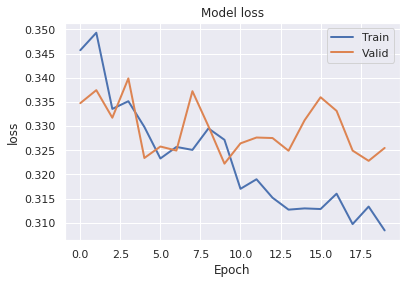

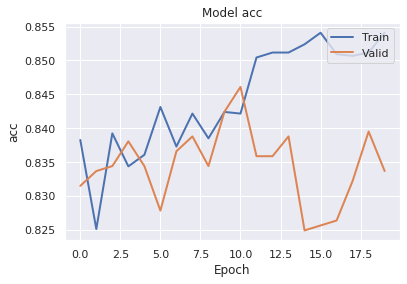

In [157]:
sns.set()

for graph in ['loss', 'acc']:
    
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    
    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    
    plt.show()

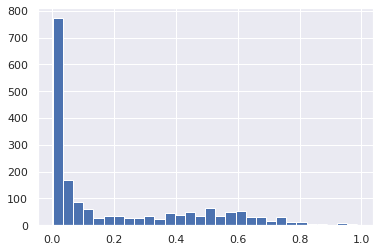

LSTM model: 2.193, 0.532, 0.242


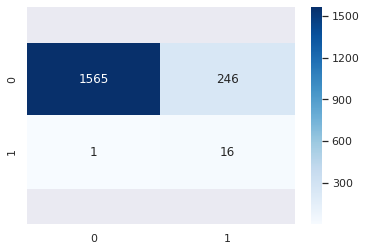

Constant prediction: 13.123, 0.588, 0.045


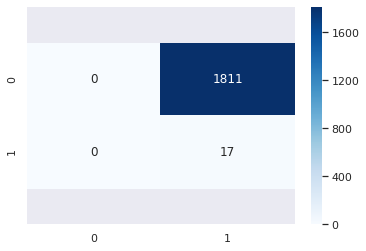

Predicting last value: 1.318, 0.571, 0.433


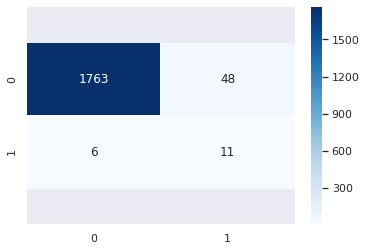

In [168]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001
classification_threshold = 0.561

def evaluate(name, y_pred):
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = best_model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate("LSTM model:", y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)

Predicting last value: 17.412, 7.540, 0.433


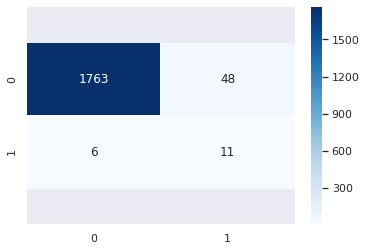

In [140]:
#Predicting last value
def recurrent_evaluate(name, y_pred):
    
    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, 2)
    
    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)
    
    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    
y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)